# CNN and Computer Vision

## Part 4 - Transfer Learning

### Importing libraries and data

In [3]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib
import cv2
import PIL
import glob

from sklearn.decomposition import PCA, IncrementalPCA

import keras
from keras.layers import Dense,Dropout, BatchNormalization, Activation, Flatten, Input
from keras.models import Sequential
from keras.activations import relu
from keras.optimizers import Adam,RMSprop,SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input, VGG16
# from keras.utils import to_categorical

from keras.preprocessing import image
from PIL import Image

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as pr

In [6]:
print(tf.__version__)

2.5.0


In [7]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [8]:
train_folder='drive/My Drive/Projects/Computer Vision/jpg'
pred_folder='drive/My Drive/Projects/Computer Vision'

### Analysing and Visualizing data

In [9]:
data_dir_train = pathlib.Path(train_folder)

folder_train = list(data_dir_train.glob('*'))
images_train = list(data_dir_train.glob('*/*.jpg')) #list of all images (full path)
print('Folder Structure:')
for f in folder_train:
    print(f)
print('\nNumber of images: ', len(images_train))

Folder Structure:
drive/My Drive/Projects/Computer Vision/jpg/Flower 1
drive/My Drive/Projects/Computer Vision/jpg/Flower 2
drive/My Drive/Projects/Computer Vision/jpg/Flower 3
drive/My Drive/Projects/Computer Vision/jpg/Flower 4
drive/My Drive/Projects/Computer Vision/jpg/Flower 5
drive/My Drive/Projects/Computer Vision/jpg/Flower 6
drive/My Drive/Projects/Computer Vision/jpg/Flower 7
drive/My Drive/Projects/Computer Vision/jpg/Flower 8
drive/My Drive/Projects/Computer Vision/jpg/Flower 9
drive/My Drive/Projects/Computer Vision/jpg/Flower 10
drive/My Drive/Projects/Computer Vision/jpg/Flower 11
drive/My Drive/Projects/Computer Vision/jpg/Flower 12
drive/My Drive/Projects/Computer Vision/jpg/Flower 13
drive/My Drive/Projects/Computer Vision/jpg/Flower 14
drive/My Drive/Projects/Computer Vision/jpg/Flower 15
drive/My Drive/Projects/Computer Vision/jpg/Flower 16
drive/My Drive/Projects/Computer Vision/jpg/Flower 17

Number of images:  1360


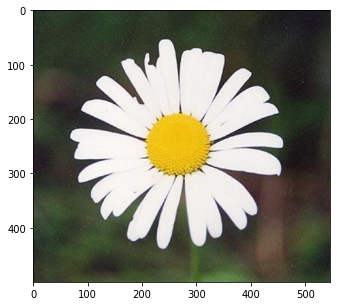

In [10]:
filenames = glob.glob("drive/My Drive/Projects/Computer Vision/jpg/Flower 11/*.jpg")
filenames.sort()
images = [cv2.imread(img) for img in filenames]

plt.figure(figsize= (20,5));

plt.imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB));

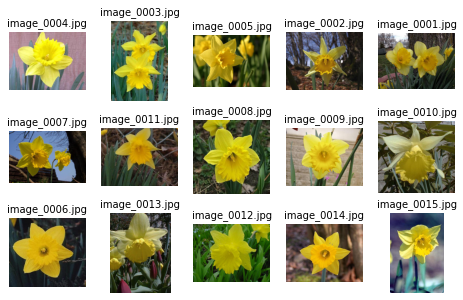

In [11]:
fig = plt.figure(figsize=(8, 5))

for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.title(str(images_train[i]).split('/')[-1], fontsize=10) #get the file name and display as title
    plt.imshow(PIL.Image.open(images_train[i]))
    ax = plt.axis("off")

### Model Building

In [ ]:
batch_size = 16

#Data Augmentation
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2)


#Normalize
test_datagen = ImageDataGenerator(rescale=1./255)


train_gen = train_datagen.flow_from_directory(
                                                     'drive/My Drive/Projects/Computer Vision/jpg',  
                                                      target_size=(224, 224),  
                                                      batch_size=batch_size,
                                                      class_mode='categorical',
                                                      subset="training")  

validation_gen = train_datagen.flow_from_directory(
                                                         'drive/My Drive/Projects/Computer Vision/jpg',  
                                                          target_size=(224, 224),  
                                                          batch_size=batch_size,
                                                          class_mode='categorical',
                                                          subset="validation") 

Found 1088 images belonging to 17 classes.
Found 272 images belonging to 17 classes.


In [ ]:
classes = train_gen.class_indices
print(classes)
class_names = []
for c in classes:
    class_names.append(c)
print('The name of the classes are: ', class_names)

{'Flower 1': 0, 'Flower 10': 1, 'Flower 11': 2, 'Flower 12': 3, 'Flower 13': 4, 'Flower 14': 5, 'Flower 15': 6, 'Flower 16': 7, 'Flower 17': 8, 'Flower 2': 9, 'Flower 3': 10, 'Flower 4': 11, 'Flower 5': 12, 'Flower 6': 13, 'Flower 7': 14, 'Flower 8': 15, 'Flower 9': 16}
The name of the classes are:  ['Flower 1', 'Flower 10', 'Flower 11', 'Flower 12', 'Flower 13', 'Flower 14', 'Flower 15', 'Flower 16', 'Flower 17', 'Flower 2', 'Flower 3', 'Flower 4', 'Flower 5', 'Flower 6', 'Flower 7', 'Flower 8', 'Flower 9']


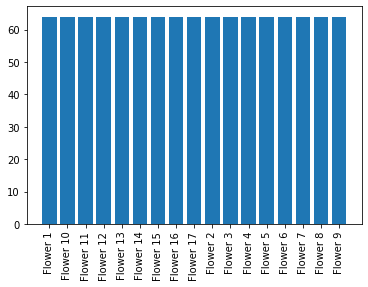

In [ ]:
unique, counts = np.unique(train_gen.classes, return_counts=True)
dict1 = dict(zip(train_gen.class_indices, counts))

keys = dict1.keys()
values = dict1.values()

plt.xticks(rotation='vertical')
bar = plt.bar(keys, values)

All the flower images are equal in number.

In [ ]:
#Fine tune a pretained VGG16 model

def vgg16_model():
    vgg_conv = VGG16(weights= "imagenet" , include_top=False, 
                     input_shape=(224, 224, 3))
    vgg_conv.trainable = False
    model = Sequential()
    
    for layer in vgg_conv.layers:
        model.add(layer)

    # Add new layers
    model.add(Flatten())
    model.add(Dropout(0.3)) 
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(17, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = vgg16_model()
model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________

In [ ]:
# You can save the best model to the checkpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint('Transfer_Learning.h5', #where to save the model
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose = 1)

In [ ]:
history = model.fit(
          train_gen,
          steps_per_epoch= 1088 // batch_size,
          epochs= 10,
          callbacks = [checkpoint],
          validation_data=validation_gen)

Epoch 1/10
68/68 [==============================] - 700s 10s/step - loss: 1.8552 - accuracy: 0.4017 - val_loss: 1.3344 - val_accuracy: 0.6728

Epoch 00001: val_accuracy improved from -inf to 0.67279, saving model to Transfer_Learning.h5
Epoch 2/10
68/68 [==============================] - 694s 10s/step - loss: 1.3829 - accuracy: 0.5643 - val_loss: 1.0540 - val_accuracy: 0.7059

Epoch 00002: val_accuracy improved from 0.67279 to 0.70588, saving model to Transfer_Learning.h5
Epoch 3/10
68/68 [==============================] - 692s 10s/step - loss: 1.1626 - accuracy: 0.6287 - val_loss: 0.9531 - val_accuracy: 0.7463

Epoch 00003: val_accuracy improved from 0.70588 to 0.74632, saving model to Transfer_Learning.h5
Epoch 4/10
68/68 [==============================] - 694s 10s/step - loss: 0.9338 - accuracy: 0.6985 - val_loss: 0.6067 - val_accuracy: 0.8162

Epoch 00004: val_accuracy improved from 0.74632 to 0.81618, saving model to Transfer_Learning.h5
Epoch 5/10
68/68 [=========================

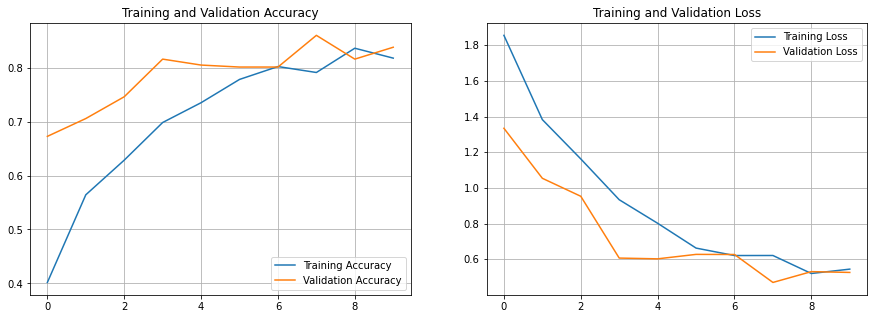

In [ ]:
epochs = 10

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid()

plt.show()

### Predicting image

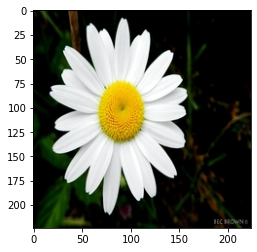

In [39]:
pred = cv2.imread(pred_folder+'/Prediction - Flower.jpg')
ax = plt.imshow(cv2.cvtColor(pred, cv2.COLOR_BGR2RGB));

In [ ]:
pred = cv2.resize(pred, (224,224))
pred_batch = np.expand_dims(pred, axis=0)
conv_pred = model.predict(pred_batch)
conv_pred.shape

(1, 17)

In [ ]:
score = tf.nn.softmax(conv_pred[0])

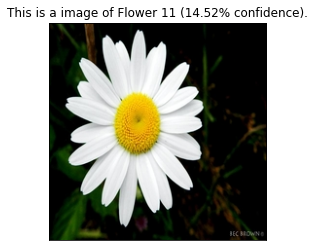

In [ ]:
simple_model = tf.keras.models.Sequential()
simple_model.add(tf.keras.layers.Conv2D(1,3,3,input_shape=pred.shape)) # 3x3 kernel

pred_batch = np.expand_dims(pred, axis=0)
conv_pred2 = simple_model.predict(pred_batch)
conv_pred2 = np.squeeze(conv_pred2, axis=0)
    
# print(conv_pred2.shape)
conv_pred2 = conv_pred2.reshape(conv_pred2.shape[:2])
# print(conv_pred2.shape)

# ax = plt.imshow(conv_pred2)
# ax = plt.imshow(pred)
ax = plt.imshow(cv2.cvtColor(pred, cv2.COLOR_BGR2RGB));
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
# print('')
ax = plt.title("This is a image of {} ({:.2f}% confidence).".format(class_names[np.argmax(score)], 100 * np.max(score)), fontsize=12)

### Applying filters to an image

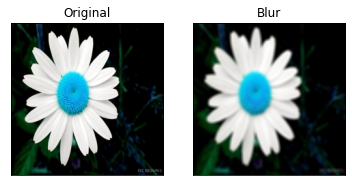

In [40]:
blur = cv2.blur(pred,(5,5))

plt.subplot(121),plt.imshow(pred),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(blur),plt.title('Blur')
plt.xticks([]), plt.yticks([])

plt.show()

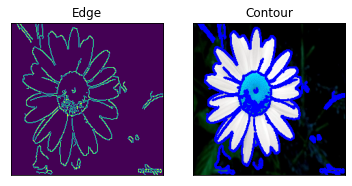

In [41]:
g = cv2.cvtColor(pred,cv2.COLOR_RGB2GRAY)
edge = cv2.Canny(g, 60, 180)

ctrs = cv2.findContours(edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contour = cv2.drawContours(pred, ctrs[0], -1, (0,0,255), thickness = 2)

plt.subplot(121),plt.imshow(edge),plt.title('Edge')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(contour),plt.title('Contour')
plt.xticks([]), plt.yticks([])

plt.show()

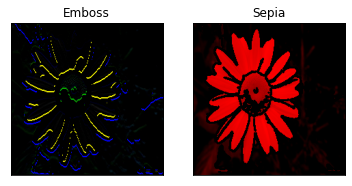

In [42]:
# Creating our emboss filter
filter1 = np.array([[0,1,0],[0,0,0],[0,-1,0]])
# Applying cv2.filter2D function on our Cybertruck image
emboss=cv2.filter2D(pred,-1,filter1)
emboss=emboss_img_1+128

filter2 = np.array([[0.272, 0.534, 0.131], [0.349, 0.686, 0.168], [0.393, 0.769, 0.189]])
sepia=cv2.transform(pred,filter)

plt.subplot(121),plt.imshow(emboss),plt.title('Emboss')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(sepia),plt.title('Sepia')
plt.xticks([]), plt.yticks([])

plt.show()

### Comparing all models

In [43]:
data = {'Accuracy': [23.74, 38.49, 67.06, 86.03],
        'Epochs': ['Na', '20', '15', '10']}

pd.DataFrame(data,
             index = ['Supervised Learning', 'Neural Network', 'Convolutional Neural Network', 'Transfer Learning'])

,Accuracy,Epochs
Supervised Learning,23.74,Na
Neural Network,38.49,20
Convolutional Neural Network,67.06,15
Transfer Learning,86.03,10


The main advantages of transfer learning are:
- Improved baseline performance: When we augment the knowledge of an isolated learner (also known as an ignorant learner) with knowledge from a source model, the baseline performance might improve due to this knowledge transfer.
- Model-development time: Utilizing knowledge from a source model might also help in fully learning the target task, as compared to a target model that learns from scratch. This, in turn, results in improvements in the overall time taken to develop/learn a model.

## Part 5

Strategies to maintain and support the AIML image classifier after it in production:
- Proactive Model Monitoring: We have continuously track the health of the machine learning model against a set of key indicators and generate specific event-based alerts.
- Reactive Model Monitoring: The goal of Reactive Model Maintenance is to identify what led to an erroneous output in a specific test sample and how it can be rectified.
- Addressing the Root Cause instead of the Symptoms: Just like accurate medical diagnosis comes from analysis of the patient’s history, proactive model maintenance has to be broad enough to quickly help identify the root cause of a customer escalation.
- Finally we have to keep our models up to date to try increasing performance time to time.